In [81]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL
import cv2
from datasets import Dataset, Image, load_dataset, Features, Array3D, ClassLabel
import matplotlib.pyplot as plt
import loralib as lora

# Dataset Preparation

## Helper functions

In [82]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset

def process_data(image_file, mask=False):
    image = PIL.Image.open(image_file)
    if not mask:
        image = image.convert("RGB")
    image = image.resize((256, 256), PIL.Image.BILINEAR)
    return np.array(image)

## Load in subset of raw data as numpy arrays

In [83]:
subset_size = 230

train_filelist_xray = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png'), key=numericalSort)
x_train = np.array([process_data(file_xray) for file_xray in train_filelist_xray[:subset_size]])

masks = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png'), key=numericalSort)
y_train = np.array([process_data(m, mask=True) for m in masks[:subset_size]])
# binarize mask
y_train[y_train > 0] = 1 

print(f"Train data shape: {x_train.shape}")
print(f"Labels (masks) data shape: {y_train.shape}")

Train data shape: (230, 256, 256, 3)
Labels (masks) data shape: (230, 256, 256)


## Make dataset dictionary

In [84]:
dataset = create_dataset(x_train, y_train)
dataset

/opt/conda/lib/python3.11/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/opt/conda/lib/python3.11/site-packages/datasets/features/image.py:341: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Dataset({
    features: ['image', 'label'],
    num_rows: 230
})

## Display sample

(-0.5, 255.5, 255.5, -0.5)

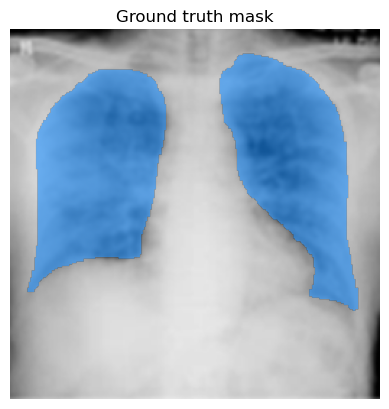

In [85]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

example = dataset[3]
image = example["image"]
fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes, False)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## SAM Dataset Prep

In [86]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  return bbox

In [87]:
from torch.utils.data import Dataset
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)
    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    return inputs

# Fine-tuning

In [88]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [89]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [90]:
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [91]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [92]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda:0")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [93]:
model.mask_decoder

SamMaskDecoder(
  (iou_token): Embedding(1, 256)
  (mask_tokens): Embedding(4, 256)
  (transformer): SamTwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x SamTwoWayAttentionBlock(
        (self_attn): SamAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (layer_norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (cross_attn_token_to_image): SamAttention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (layer_norm2): LayerNorm((256,

In [94]:
sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"SAM total params: {sam_mask_decoder_total_params}")

SAM total params: 4058340


In [95]:
(4058340-3600612)/4058340

0.11278700158192759

## LoRA integration

In [96]:
for layer in model.mask_decoder.transformer.layers:
    layer.self_attn.q_proj = lora.Linear(256, 256, r=8)
    layer.self_attn.k_proj = lora.Linear(256, 256, r=8)
    layer.self_attn.v_proj = lora.Linear(256, 256, r=8)

In [97]:
model.mask_decoder.transformer.final_attn_token_to_image.q_proj = lora.Linear(256, 128, r=8)
model.mask_decoder.transformer.final_attn_token_to_image.k_proj = lora.Linear(256, 128, r=8)
model.mask_decoder.transformer.final_attn_token_to_image.v_proj = lora.Linear(256, 128, r=8)

In [98]:
sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"LoRA-SAM total params: {sam_total_params}")

LoRA-SAM total params: 3600612


In [99]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [101]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10
mean_epoch_losses = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    mean_loss = mean(epoch_losses)
    print(f'Mean loss: {mean_loss}')
    mean_epoch_losses.append(mean_loss)

100%|██████████| 115/115 [00:35<00:00,  3.25it/s]


EPOCH: 0
Mean loss: 0.7751521177913832


100%|██████████| 115/115 [00:35<00:00,  3.25it/s]


EPOCH: 1
Mean loss: 0.6370971293553062


100%|██████████| 115/115 [00:35<00:00,  3.24it/s]


EPOCH: 2
Mean loss: 0.5717791557312012


100%|██████████| 115/115 [00:35<00:00,  3.24it/s]


EPOCH: 3
Mean loss: 0.5175743557836698


100%|██████████| 115/115 [00:35<00:00,  3.23it/s]


EPOCH: 4
Mean loss: 0.481259875971338


100%|██████████| 115/115 [00:35<00:00,  3.21it/s]


EPOCH: 5
Mean loss: 0.45246873679368393


100%|██████████| 115/115 [00:35<00:00,  3.20it/s]


EPOCH: 6
Mean loss: 0.43007756342058595


100%|██████████| 115/115 [00:39<00:00,  2.91it/s]


EPOCH: 7
Mean loss: 0.40615367785744044


100%|██████████| 115/115 [00:53<00:00,  2.17it/s]


EPOCH: 8
Mean loss: 0.39920614763446477


100%|██████████| 115/115 [00:53<00:00,  2.16it/s]

EPOCH: 9
Mean loss: 0.3851791096770245


# Inference

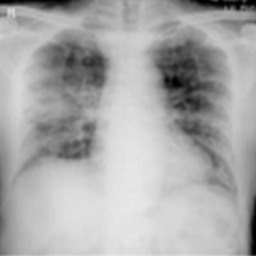

In [102]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 3

# load image
image = dataset[idx]["image"]
image

In [103]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [104]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [105]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(1, 1, 4)
(256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

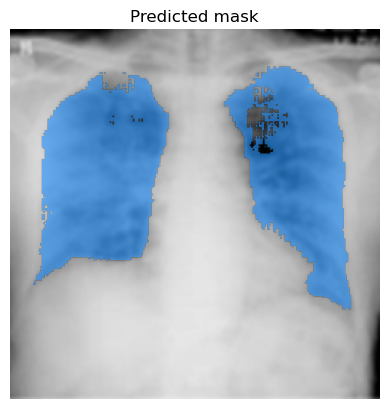

In [106]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    print(color.reshape(1, 1, -1).shape)
    print(mask.reshape(h, w, 1).shape)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

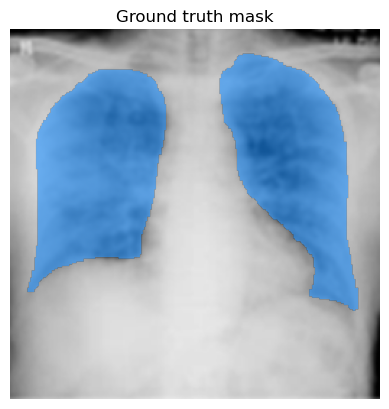

In [107]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

example = dataset[3]
image = example["image"]
fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes, False)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")